**Data Collection & Preprocessing**

**Objective:**

**Goal:** To predict future inventory needs using historical sales data to optimize inventory levels, reduce holding costs, and avoid stockouts.

In [1]:
import pandas as pd
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

# Generate date range for 2 years (e.g., 2021-2022)
date_range = pd.date_range(start='2021-01-01', end='2022-12-31', freq='D')

# Generate synthetic sales data with some seasonality and noise
sales = np.random.poisson(lam=(50 + 10 * np.sin(2 * np.pi * (date_range.dayofyear / 365))), size=len(date_range))

# Create a DataFrame
retail_data = pd.DataFrame({
    'Date': date_range,
    'Sales': sales,
    'Category': np.random.choice(['Electronics', 'Clothing', 'Grocery', 'Furniture'], size=len(date_range))
})

# Save to CSV
retail_data.to_csv('retail_sales.csv', index=False)

# Display the first few rows
retail_data.head()


,Date,Sales,Category
0,2021-01-01,47,Clothing
1,2021-01-02,55,Furniture
2,2021-01-03,42,Furniture
3,2021-01-04,53,Furniture
4,2021-01-05,59,Electronics


In [2]:
# Load the CSV into a DataFrame
data = pd.read_csv('retail_sales.csv', parse_dates=['Date'])
data.head()


,Date,Sales,Category
0,2021-01-01,47,Clothing
1,2021-01-02,55,Furniture
2,2021-01-03,42,Furniture
3,2021-01-04,53,Furniture
4,2021-01-05,59,Electronics


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      730 non-null    datetime64[ns]
 1   Sales     730 non-null    int64         
 2   Category  730 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.2+ KB
None
                      Date       Sales
count                  730  730.000000
mean   2021-12-31 12:00:00   49.860274
min    2021-01-01 00:00:00   27.000000
25%    2021-07-02 06:00:00   42.000000
50%    2021-12-31 12:00:00   49.000000
75%    2022-07-01 18:00:00   57.000000
max    2022-12-31 00:00:00   80.000000
std                    NaN   10.740725


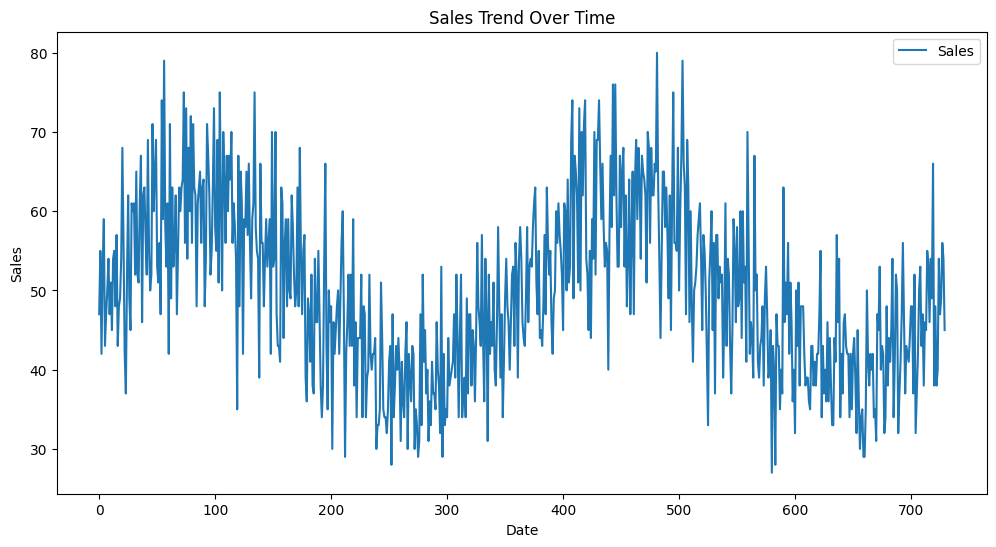

Date        0
Sales       0
Category    0
dtype: int64


<ipython-input-5-0395e9183f14>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


# Display basic information about the dataset
print(data.info())
print(data.describe())

# Visualize the sales trend over time
plt.figure(figsize=(12, 6))
plt.plot(data['Sales'], label='Sales')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Check for missing values
print(data.isnull().sum())

# Handle missing values (if any)
data.fillna(method='ffill', inplace=True)

**Exploratory Data Analysis (EDA)**

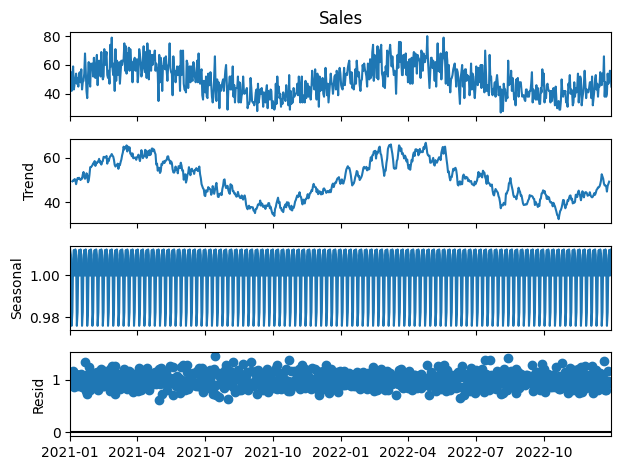

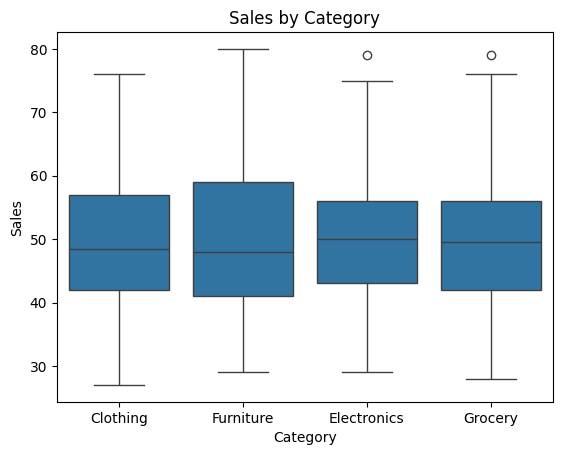

In [7]:
# Plotting seasonal decomposition
# Set the 'Date' column as the index and specify the frequency
data.set_index('Date', inplace=True)
data = data.asfreq('D')  # Set frequency to daily ('D')

decompose_result = seasonal_decompose(data['Sales'], model='multiplicative')
decompose_result.plot()
plt.show()

# Visualize sales by different categories if available (Example)
sns.boxplot(x='Category', y='Sales', data=data.reset_index())  # Reset index for boxplot
plt.title('Sales by Category')
plt.show()

**Time Series Analysis & Model Building**

ARIMA RMSE: 9.817419954360474, MAE: 7.831812440039878


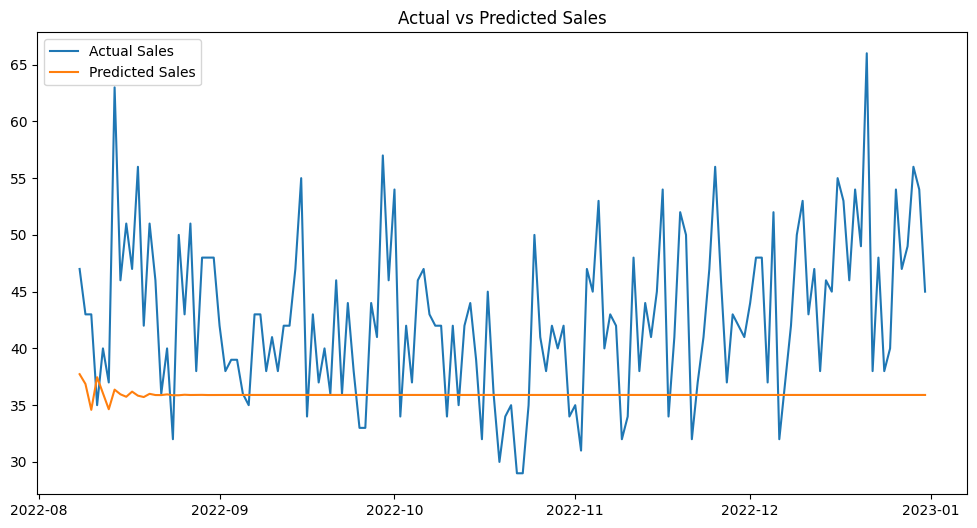

In [8]:
# Import ARIMA and Prophet for forecasting
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Split data into training and test sets (80-20 split)
train_size = int(len(data) * 0.8)
train, test = data['Sales'][:train_size], data['Sales'][train_size:]

# Build and fit the ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))  # Adjust the order (p, d, q) based on ACF/PACF plots
arima_fit = arima_model.fit()

# Make predictions
arima_predictions = arima_fit.forecast(steps=len(test))

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test, arima_predictions))
mae = mean_absolute_error(test, arima_predictions)
print(f'ARIMA RMSE: {rmse}, MAE: {mae}')

# Plot predictions vs. actual sales
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Sales')
plt.plot(test.index, arima_predictions, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()


**Recommendations & Inventory Optimization**

In [9]:
# Calculate safety stock based on standard deviation and lead time
lead_time = 7  # Example lead time in days
std_sales = np.std(train[-lead_time:])  # Standard deviation over last 'lead_time' days
safety_stock = 1.65 * std_sales  # Assuming 95% service level

# Define reorder point
average_demand = np.mean(train[-lead_time:])
reorder_point = lead_time * average_demand + safety_stock

print(f'Reorder Point: {reorder_point}, Safety Stock: {safety_stock}')


Reorder Point: 272.8326038477574, Safety Stock: 10.832603847757424
